# Correctly Calculating Annual Averages with Xarray

A common component of people's workflows is calculating annual averages, which helps **reduce** the frequency of datasets, making them easier to work with. Two of the data frequencies you may be looking to convert to annual include:
* Daily (365 days in each year)
* Monthly (12 months in a year)

## The Data

When using the daily data, calculating the averages is relatively straightforward since we do not have to do any ***weighting***, taking the length of each time into account. We know that each day is equal in length, and there are 365 days in each year.

This is **not** the case with monthly data. When converting monthly frequency into annual frequency, we need to take the length of each month into account since not each month is created equal. For example, February has 28 days whereas December has 31 - we need to make sure to get the weights right.

In this example, we will be using monthly data from the CESM2-Large Ensemble which is stored on AWS.

## The Problem
Within `Xarray`, it can be tempting to use the `resample` or `groupby` functions to calculate your annual average, but you need to be careful here! By default these functions **do not** take the weight of the frequencies into account. We need to write a specialized workflow to account for this!

Here is a preview of how far off two different, seemingly similar methods of calculating annual averages with `Xarray` are!

![comparison](../images/incorrect_vs_correct_weighting.png)

## The Solution

Let's dig into our solution - we will start by computing the yearly average from monthly data using `resample`, which is considered the ***"incorrect"*** method. Then, we will provide an example of calculating the proper weights, and applying these to our ***"correct"*** weighted average.

### Imports
We use some typical libraries (`Xarray`, `Numpy`, and `Dask`), along with some visualization packages (`hvPlot` and `holoviews`).

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
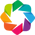

In [2]:
import holoviews as hv
import hvplot
import hvplot.xarray
import numpy as np
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster

hv.extension('bokeh')

### Spin up a Cluster
We use our `NCARCluster` here and pass it to our Dask Client

In [3]:
cluster = NCARCluster()
cluster.scale(20)
client = Client(cluster)
client

/glade/work/mgrover/miniconda3/envs/cesm-collections-dev/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37603 instead
  warnings.warn(


<Client: 'tcp://10.12.206.57:33692' processes=0 threads=0, memory=0 B>

### Load in the CESM2-LE Data
We are using monthly potential temperature data from the CESM2 Large Ensemble. If you are interested in learning more about this dataset, check out the previous [ESDS blog post](https://ncar.github.io/esds/posts/2021/kay-et-al-cesm2-le/) looking at data from this ensemble.

In [4]:
ds = xr.open_zarr(
    's3://ncar-cesm2-lens/ocn/monthly/cesm2LE-ssp370-cmip6-TEMP.zarr',
    storage_options={'anon': True},
)

You'll notice we have data from 2015 to 2100 - at monthly frequency! Let's subset the first six years and first five ensemble members as a benchmark.

In [5]:
ds_first_five_years = ds.sel(time=slice('2015', '2019')).isel(member_id=range(5))
ds_first_five_years

<xarray.Dataset>
Dimensions:     (member_id: 5, time: 60, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) <U12 'r10i1181p1f1' ... 'r10i1301p1f1'
  * time        (time) object 2015-01-16 12:00:00 ... 2019-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(60, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    calendar:          All years have exactly  365 days.
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    contents:          Diagnostic and Prognostic Variables
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    revision:          $Id$
    source:            CCSM POP2, the CCSM Ocean Component
    time_period_freq:  month_1

### Calculate the Annual Average **Incorrectly**

We can try using resample here to calculate the annual average, from a subset of the data

The `resample` method comes from Pandas! If you are interested in learning more about this functionality, check out [their docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)

The frequency we are looking for is `AS`, which is the annual frequency.

We can calculate our resampled dataset using the following

In [6]:
resampled = ds_first_five_years.resample(time='AS').mean('time')

This will lazily calculate the data - in order to check to see how long this takes, we can add the `%%time` magic command at the top of the cell

In [7]:
%%time
yearly_average_weighted_incorrectly = resampled.compute()

CPU times: user 970 ms, sys: 1.28 s, total: 2.25 s
Wall time: 19.8 s


Let's get a quick plot of the data!

/glade/work/mgrover/miniconda3/envs/cesm-collections-dev/lib/python3.9/site-packages/xarray/plot/plot.py:1476: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  primitive = ax.pcolormesh(x, y, z, **kwargs)


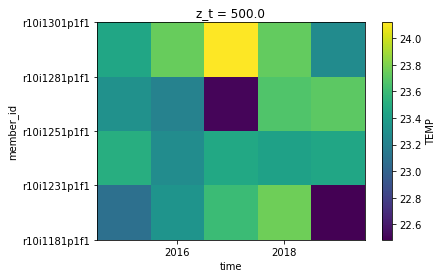

In [8]:
yearly_average_weighted_incorrectly.TEMP.isel(z_t=0, nlat=100, nlon=100).plot(x='time');

### Calculating the Yearly Average **Correctly**
As mentioned previously, we need to weight the months correctly. We can do this by determining how many days are in each month.

We can use the `.dt` method on the times in our dataset to extract the number of days in each month! Which can be **super** helpful 👍

In [9]:
month_length = ds_first_five_years.time.dt.days_in_month
month_length

<xarray.DataArray 'days_in_month' (time: 60)>
array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2019-12-16 12:00:00

We can calculate our weights using the following, which results in an `xarray.DataArray` with the corresponding weights.

Notice how longer months (ex. months with 31 days) have a **higher weight** than months with less days (ex. 28)

In [10]:
wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
wgts

<xarray.DataArray 'days_in_month' (time: 60)>
array([0.08493151, 0.07671233, 0.08493151, 0.08219178, 0.08493151,
       0.08219178, 0.08493151, 0.08493151, 0.08219178, 0.08493151,
       0.08219178, 0.08493151, 0.08493151, 0.07671233, 0.08493151,
       0.08219178, 0.08493151, 0.08219178, 0.08493151, 0.08493151,
       0.08219178, 0.08493151, 0.08219178, 0.08493151, 0.08493151,
       0.07671233, 0.08493151, 0.08219178, 0.08493151, 0.08219178,
       0.08493151, 0.08493151, 0.08219178, 0.08493151, 0.08219178,
       0.08493151, 0.08493151, 0.07671233, 0.08493151, 0.08219178,
       0.08493151, 0.08219178, 0.08493151, 0.08493151, 0.08219178,
       0.08493151, 0.08219178, 0.08493151, 0.08493151, 0.07671233,
       0.08493151, 0.08219178, 0.08493151, 0.08219178, 0.08493151,
       0.08493151, 0.08219178, 0.08493151, 0.08219178, 0.08493151])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2019-12-16 12:00:00
    year     (time) int64 2015 2015 2015 2015 2015 ... 2019 2019 2019 2019 2019

We should run a test to make sure that all these weights add up to 1, which can be accomplished using a helpful `numpy.testing` function.

This is making sure that sum of each year's weights is equal to 1!

In [11]:
np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

We ***could*** just print out the sum to take a look too

In [12]:
wgts.groupby("time.year").sum(xr.ALL_DIMS)

<xarray.DataArray 'days_in_month' (year: 5)>
array([1., 1., 1., 1., 1.])
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019

Now that we have our weights, we need to apply them to our dataset. We can still use resample here too!

In [13]:
temp = ds_first_five_years['TEMP']
temp

<xarray.DataArray 'TEMP' (member_id: 5, time: 60, z_t: 60, nlat: 384, nlon: 320)>
dask.array<getitem, shape=(5, 60, 60, 384, 320), dtype=float32, chunksize=(1, 6, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r10i1301p1f1'
  * time       (time) object 2015-01-16 12:00:00 ... 2019-12-16 12:00:00
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    coordinates:   TLONG TLAT z_t time
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

We want to make sure our missing (`nan`) values are not impacting our weights, so we mask these out

In [14]:
cond = temp.isnull()
ones = xr.where(cond, 0.0, 1.0)

Next, we calculate our numerator, which is our value (`TEMP`) multiplied by our weights

In [15]:
temp_sum = (temp * wgts).resample(time="AS").sum(dim="time")

Next, we calculate our denominator which is our `ones` array multiplied by our weights

In [16]:
ones_sum = (ones * wgts).resample(time="AS").sum(dim="time")

Now that we have our numerator (`temp_sum`) and denominator (`ones_sum`), we can calculate our weighted average!

In [17]:
average_weighted_temp = temp_sum / ones_sum
average_weighted_temp

<xarray.DataArray (member_id: 5, time: 5, z_t: 60, nlat: 384, nlon: 320)>
dask.array<truediv, shape=(5, 5, 60, 384, 320), dtype=float64, chunksize=(1, 1, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 2015-01-01 00:00:00 ... 2019-01-01 00:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r10i1301p1f1'
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon

#### Wrap it Up into a Function
We can wrap this into a function, which can be helpful when implementing into your workflow!

In [18]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [19]:
average_weighted_temp = weighted_temporal_mean(ds_first_five_years, 'TEMP')
average_weighted_temp

<xarray.DataArray (member_id: 5, time: 5, z_t: 60, nlat: 384, nlon: 320)>
dask.array<truediv, shape=(5, 5, 60, 384, 320), dtype=float64, chunksize=(1, 1, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 2015-01-01 00:00:00 ... 2019-01-01 00:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r10i1301p1f1'
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon

In [20]:
%%time
yearly_average_weighted_correctly = average_weighted_temp.compute()

CPU times: user 1.25 s, sys: 2.05 s, total: 3.29 s
Wall time: 9.61 s


Let's plot a quick visualization again!

/glade/work/mgrover/miniconda3/envs/cesm-collections-dev/lib/python3.9/site-packages/xarray/plot/plot.py:1476: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  primitive = ax.pcolormesh(x, y, z, **kwargs)


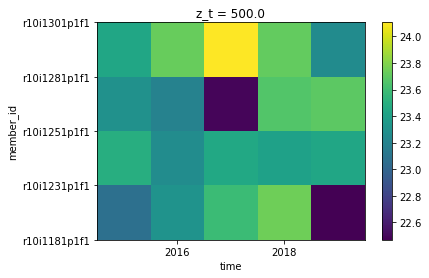

In [21]:
yearly_average_weighted_correctly.isel(z_t=0, nlat=100, nlon=100).plot(x='time');

### Take a Look at the Difference
Let's create a plotting function here to take a look at the difference between the two!

In [28]:
def plot_field(ds, label, cmap='magma', vmin=0, vmax=35):
    ds['nlat'] = ds.nlat
    ds['nlon'] = ds.nlon
    return ds.hvplot.quadmesh(
        x='nlon',
        y='nlat',
        rasterize=True,
        cmap=cmap,
        title=label,
        clim=(vmin, vmax),
        clabel='TEMP (degC)',
    )

We first setup our plots, adding labels and adjusting for the lower (correct) values of temperature for the `correct_plot`.

In [29]:
incorrect_plot = plot_field(yearly_average_weighted_incorrectly.TEMP, label='Incorrect Weighting')
correct_plot = plot_field(yearly_average_weighted_correctly, label='Correct Weighting')

We can also take the difference between the two, with the variable being `difference`.

In [30]:
difference = yearly_average_weighted_incorrectly.TEMP - yearly_average_weighted_correctly

Since ***most*** of our values are much larger for the incorrect weigthing, we use a red colobar for that plot.

In [37]:
difference_plot = plot_field(difference, 'Incorrect - Correct Weighting', cmap='Reds', vmax=0.05)

We can visualize our plots stacked on top of each other, by using `hv.Layout` and specifying `.cols(1)` which will keep them in a single column.

In [38]:
hv.Layout([incorrect_plot, correct_plot, difference_plot]).cols(1)

:Layout
   .DynamicMap.I   :DynamicMap   [z_t,member_id,time]
      :Image   [nlon,nlat]   (TEMP)
   .DynamicMap.II  :DynamicMap   [z_t,member_id,time]
      :Image   [nlon,nlat]   (value)
   .DynamicMap.III :DynamicMap   [z_t,member_id,time]
      :Image   [nlon,nlat]   (value)

## Conclusion
Time can be a tricky thing when working with `Xarray` - if you aren't careful, you may be calculating your averages incorrectly!

This example covered how to efficiently calculate annual averages from monthly data, weighting by the number of days in each month.

Weighting incorrectly can cause **large errors** within your analysis, so be sure to know when to use weighted averages.